In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.stats
import itertools

Рассмотрим данные о кредитных историях клиентов одного из банков. Поля в предоставляемых данных имеют следующий смысл: 

* LIMIT_BAL:  размер кредитного лимита (в том числе и на семью клиента)
* SEX: пол клиента (1 = мужской, 2 = женский )
* EDUCATION: образование (0 = доктор, 1 = магистр; 2 = бакалавр; 3 = выпускник школы; 4 = начальное образование; 5= прочее; 6 = нет данных ).
* MARRIAGE: (0 = отказываюсь отвечать; 1 = замужем/женат; 2 = холост; 3 = нет данных). 
* AGE: возраст в годах
* PAY_0 - PAY_6 : История прошлых платежей по кредиту. PAY_6 - платеж в апреле, ... Pay_0 - платеж в сентябре. Платеж = (0 = исправный платеж, 1=задержка в один месяц, 2=задержка в 2 месяца ...)
* BILL_AMT1 - BILL_AMT6:  задолженность,  BILL_AMT6 - на апрель, BILL_AMT1 - на сентябрь 
* PAY_AMT1 - PAY_AMT6: сумма уплаченная в PAY_AMT6 - апреле, ..., PAY_AMT1 - сентябре 
* default - индикатор невозврата денежных средств

In [2]:
credit_data = pd.read_csv("credit_card_default_analysis.csv", delimiter=',')
credit_data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


Поскольку в дальнейшем мы буем решать задачи кредитного скоринга, сразу поделим набор данных на два в зависимости от факта возврата кредита по итогу.

In [3]:
credit_data_ret = credit_data[credit_data.default == 0]
credit_data_unret = credit_data[credit_data.default == 1]

### Задание 1
Размер кредитного лимита (LIMIT_BAL). В двух группах, тех людей, кто вернул кредит (default = 0) и тех, кто его не вернул (default = 1) проверьте гипотезы:   a)  о равенстве медианных значений кредитного лимита с помощью подходящей интервальной оценки  b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних.  Значимы ли полученные результаты с практической точки зрения ?

In [4]:
limit_bal_ret = credit_data_ret.LIMIT_BAL.rename("LIMIT_BAL_RET")
limit_bal_unret = credit_data_unret.LIMIT_BAL.rename("LIMIT_BAL_UNRET")

In [5]:
ret_unret_lb_descr = pd.concat([limit_bal_ret.describe(), limit_bal_unret.describe()], axis = 1)
ret_unret_lb_descr

,LIMIT_BAL_RET,LIMIT_BAL_UNRET
count,23364.000000,6636.000000
mean,178099.726074,130109.656420
std,131628.359660,115378.540571
min,10000.000000,10000.000000
25%,70000.000000,50000.000000
50%,150000.000000,90000.000000
75%,250000.000000,200000.000000
max,1000000.000000,740000.000000


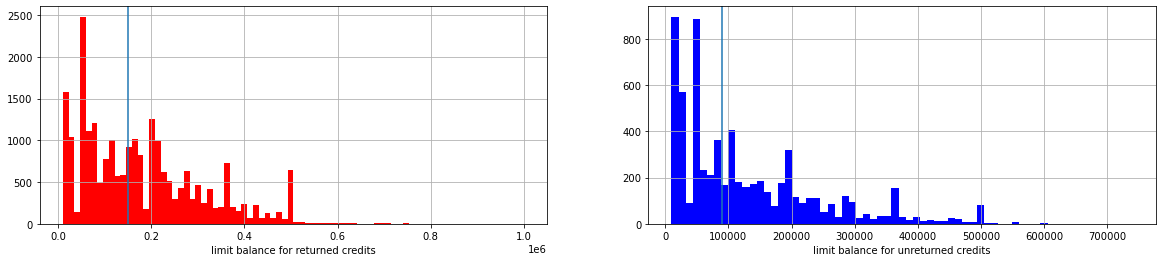

In [6]:
plt.figure(figsize=(20,4))

plt.subplot(1,2,1)
plt.hist(limit_bal_ret, color = 'r', bins = limit_bal_ret.nunique())
plt.axvline(ret_unret_lb_descr.loc["50%", "LIMIT_BAL_RET"])
plt.xlabel('limit balance for returned credits')

plt.subplot(1,2,2)
plt.hist(limit_bal_unret, color = 'b', bins = limit_bal_unret.nunique())
plt.axvline(ret_unret_lb_descr.loc["50%", "LIMIT_BAL_UNRET"])
plt.xlabel('limit balance for unreturned credits')

plt.show()

Видно, что средние значения и медианы у двух выборок заметно отличаются. Оценим значимость этого различия.

Для начала воспользуемся интервальной оценкой медиан для выборок. Поскольку про распределение оцениваемой величины нам ничего не известно, воспользуемся бутстрепированием.

In [7]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [8]:
ret_median_scores = list(map(np.median, get_bootstrap_samples(limit_bal_ret.values, 1000)))
unret_median_scores = list(map(np.median, get_bootstrap_samples(limit_bal_unret.values, 1000)))
print("95% confidence interval for the returned credits median limit balance:",  stat_intervals(ret_median_scores, 0.05))
print("95% confidence interval for the unreturned credits median limit balance:",  stat_intervals(unret_median_scores, 0.05))

95% confidence interval for the returned credits median limit balance: [150000. 150000.]
95% confidence interval for the unreturned credits median limit balance: [80000. 90000.]


Видно, что 95% доверительный интервал для медиан значительно отличается. Более того, разность значений весьма значительна (более полутора раз). Из этого можно делать выводы в пользу того, что больший размер кредитного лимита может позитивно сказывается на возвращаемости кредита. Это может объясняться тем, что кредиты на большие суммы получают более надежные клиенты.

Для того, чтобы еще больше в этом убедиться, воспольуемся статистическими критериями. Будем проверять гипотезу о равенстве распределений при помощи непараметрических критериев. 

In [9]:
pd.concat([limit_bal_ret.value_counts(),limit_bal_unret.value_counts()],axis = 1).fillna(0).head(10)

,LIMIT_BAL_RET,LIMIT_BAL_UNRET
10000,296.0,197.0
16000,2.0,0.0
20000,1278.0,698.0
30000,1042.0,568.0
40000,138.0,92.0
50000,2480.0,885.0
60000,592.0,233.0
70000,521.0,210.0
80000,1204.0,363.0
90000,485.0,166.0


Поскольку в наших данных довольно много повторяющихся значений, критерий Манна-Уитни нам не подходит. Вместо него воспользуемся перестановочным критерием. Независимость наблюдений позволяет нам сделать это.

In [10]:
def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

def get_random_combinations(n1, n2, max_combinations):
    index = list(range(n1 + n2))
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

def permutation_zero_dist_ind(sample1, sample2, max_combinations = None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr

def permutation_test(sample, mean, max_permutations = None, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    t_stat = permutation_t_stat_ind(sample, mean)
    zero_distr = permutation_zero_dist_ind(sample, mean, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr), t_stat
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr), t_stat

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr), t_stat

In [11]:
permutation_test_result_2_sided = permutation_test(limit_bal_ret, limit_bal_unret, 10000)
permutation_test_result_less = permutation_test(limit_bal_ret, limit_bal_unret, 10000, alternative="greater")

print("p-value (two-sided): %f. t-stat: %f" % permutation_test_result_2_sided)
print("p-value (greater): %f. t-stat: %f" % permutation_test_result_less)

p-value (two-sided): 0.000100. t-stat: 47990.069655
p-value (greater): 0.000100. t-stat: 47990.069655


Достигаемый уровень значимости значительно ниже порога 0.05, что позволяет нам с уверенностью отвергнуть нулевую гипотезу о равенстве распределений. Разница в t-статистике состовляет 50000, что свидетельствует  втом числе о высокой практической значимости.

### Задание 2
Пол (SEX): Проверьте гипотезу о том,  что гендерный состав  группы людей вернувших и не вернувших кредит отличается.  Хорошо, если вы предоставите несколько различных решений  этой задачи (с помощью доверительного интервала и подходящего статистического критерия)

In [12]:
sex_ret = credit_data_ret.SEX.astype(int).rename("SEX_RET")
sex_unret = credit_data_unret.SEX.astype(int).rename("SEX_UNRET")

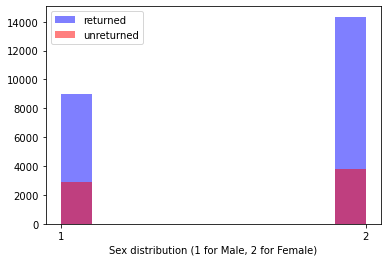

In [42]:
plt.hist(sex_ret, color = 'b', alpha = 0.5, label = "returned", align="mid")
plt.hist(sex_unret, color = 'r', alpha = 0.5, label = "unreturned", align="mid")
plt.xlabel('Sex distribution (1 for Male, 2 for Female)')
plt.xticks([1,2])
plt.legend()
plt.show()

In [14]:
sex_counts = pd.concat([sex_ret.value_counts(), sex_unret.value_counts()], axis = 1)
sex_counts

,SEX_RET,SEX_UNRET
2,14349,3763
1,9015,2873


Будем проверять гипотезу о том, что гендерный состав группы людей вернувших и не вернувших кредит отличается. Для этого будем оценивать долю женщин в каждой выборке.

In [15]:
n_ret = sex_ret.count()
female_ret_rate = sex_counts.loc[2, "SEX_RET"]/n_ret
print("Females from all returned: %f" % female_ret_rate)

n_unret = sex_unret.count()
female_unret_rate = sex_counts.loc[2, "SEX_UNRET"]/n_unret
print("Females from all unreturned: %f" % female_unret_rate)

Females from all returned: 0.614150
Females from all unreturned: 0.567058


Для нашей выборки доля женщин среди не вернувших кредит выше, чем среди вернувших. Чтобы проверить наличие статистической разницы между полом и возвратами кредитов построим доверительный интервал для разности долей женщин в выборках. 

In [16]:
def proportions_confint_diff_ind(p1, p2, n1, n2, alpha = 0.05):    
    z = scipy.stats.norm.ppf(1 - alpha / 2.)   
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ n1 + p2 * (1 - p2)/n2)
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/n1 + p2 * (1 - p2)/n2)
    return (left_boundary, right_boundary)

In [17]:
print("confidence interval: [%f, %f]" % proportions_confint_diff_ind(female_unret_rate, female_ret_rate, n_unret, n_ret))

confidence interval: [-0.060548, -0.033635]


Доверительный интервал с надежностью 95% показывает разницу в доле женщин среди не вернувших и вернувших кредит от 3.36% до 6.05%. 
Проверим гипотезу о равенстве долей при помощи Z-критерия для долей. 

In [18]:
P = (female_unret_rate * n_unret + female_ret_rate * n_ret) / (n_unret + n_ret)
z_stat = (female_unret_rate - female_ret_rate) / np.sqrt(P * (1 - P) * (1 / n_unret + 1 / n_ret))
p_val = 2 * (1 - scipy.stats.norm.cdf(np.abs(z_stat)))
print(p_val)

4.472866521609831e-12


Z-критерий для долей также позволяет с уверенностью отвергнуть гипотезу о равенстве долей женщин в разрезе по факту возврата кредита.

С практической точки зрения может быть интереснее узнать, на сколько для женщин больше доля невозврата. Рассмотрим гипотезу о равенстве доли невозврата среди мужчин и женщин.

In [19]:
n_male = sex_counts.loc[1, :].sum()
male_rate = sex_counts.loc[1, "SEX_UNRET"]/n_male
print("Male rate: %f" % male_rate)

n_female = sex_counts.loc[2, :].sum()
female_rate = sex_counts.loc[2, "SEX_UNRET"]/n_female
print("Female rate: %f" % female_rate)

Male rate: 0.241672
Female rate: 0.207763


Кажется, что женщины в нашей выборке возвращают кредиты несколько реже. Построим доверительный интервал для разности долей возвратов.

In [20]:
print("confidence interval: [%f, %f]" % proportions_confint_diff_ind(male_rate, female_rate, n_male, n_female))

confidence interval: [0.024207, 0.043612]


Доверительный интервал показывает разницу в проценте возврата мужчинами от 2.42% до 4.36%. Проверим гипотезу о равенстве долей при помощи Z-критерия.

In [21]:
P = (male_rate * n_male + female_rate * n_female) / (n_male + n_female)
z_stat = (male_rate - female_rate) / np.sqrt(P * (1 - P) * (1 / n_male + 1 / n_female))
p_val = 2 * (1 - scipy.stats.norm.cdf(np.abs(z_stat)))
print(p_val)

4.472866521609831e-12


Z-критерий для долей также позволяет с уверенностью отвергнуть гипотезу о равенстве долей возврата кредита.

### Задание 3
Образование (EDUCATION): Проверьте гипотезу о том, что образование не влияет на то, вернет ли человек долг.  Предложите способ наглядного представления разницы в ожидаемых и наблюдаемых значениях количества человек вернувших и не вернувших долг. Например, составьте таблицу сопряженности "образование" на "возврат долга", где значением ячейки была бы  разность между наблюдаемым и ожидаемым количеством человек.  Как бы вы предложили модифицировать таблицу так, чтобы привести значения ячеек к одному масштабу не потеряв в интерпретируемости ?  Наличие какого образования является наилучшим индикатором того, что человек  отдаст долг ? наоборт, не отдаст долг ?

In [22]:
ed_ret = credit_data_ret.EDUCATION.rename("ED_RET")
ed_unret = credit_data_unret.EDUCATION.rename("ED_UNRET")

In [23]:
ed_ret.value_counts()

2    10700
1     8549
3     3680
5      262
4      116
6       43
0       14
Name: ED_RET, dtype: int64

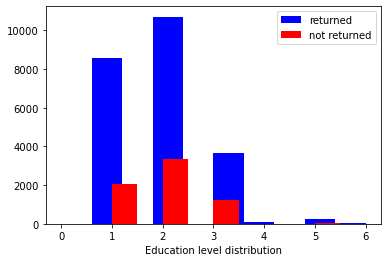

In [62]:
plt.hist(ed_ret, color = 'b',  label = "returned")
plt.hist(ed_unret, color = 'r', label = "not returned", range=[0,6], align='mid')
plt.xlabel('Education level distribution')
plt.legend()
plt.show()

Построим таблицу сопряженности для уровня образования и возврата/невозврата кредита.

In [46]:
ed_val_counts = pd.concat([ed_ret.value_counts(), ed_unret.value_counts()], axis=1).fillna(0)
ed_val_counts

,ED_RET,ED_UNRET
0,14,0.0
1,8549,2036.0
2,10700,3330.0
3,3680,1237.0
4,116,7.0
5,262,18.0
6,43,8.0


Посмотрим, как отклоняются значения относительно ожидаемых.

In [70]:
chi2 = scipy.stats.chi2_contingency(ed_val_counts)
(ed_val_counts-chi2[3])

,ED_RET,ED_UNRET
0,3.0968,-3.0968
1,305.4020,-305.4020
2,-226.5640,226.5640
3,-149.3596,149.3596
4,20.2076,-20.2076
5,43.9360,-43.9360
6,3.2812,-3.2812


Масштабируем значение, поделив на общее количество человек ссоответствующим уровнем образования.

In [48]:
(ed_val_counts-chi2).div(ed_val_counts.sum(axis=1), axis = 0)

,ED_RET,ED_UNRET
0,0.221200,-0.221200
1,0.028852,-0.028852
2,-0.016149,0.016149
3,-0.030376,0.030376
4,0.164289,-0.164289
5,0.156914,-0.156914
6,0.064337,-0.064337


Видно, что люди с докторской степенью с большей вероятностью отдают долги. Люди со средним образованием, наоборот, более склонны к невозврату кредитов. 
Проверим более строго гипотезу о неравенстве коэффициента Крамера таблицы хи-квадрат нулю.

In [80]:
print(f"p-val: {chi2[1]}")

p-val: 8.825862457577375e-08


Полученное p-value позволяет отвергнуть гипотезу о равенстве коэффициента Крамера нулю с уровнем значимости 0.05. Значит данная величина действительно влияет на результат скоринга.

### Задание 4
Семейное положение (MARRIAGE): Проверьте, как связан семейный статус с индикатором дефолта: нужно предложить меру, по которой можно измерить возможную связь этих переменных и посчитать ее значение.

In [49]:
marr_ret = credit_data_ret.MARRIAGE.rename("MARRIAGE_RET")
marr_unret = credit_data_unret.MARRIAGE.rename("MARRIAGE_UNRET")
marr_val_counts = pd.concat([marr_ret.value_counts(), marr_unret.value_counts()], axis=1).fillna(0)
marr_val_counts

,MARRIAGE_RET,MARRIAGE_UNRET
2,12623,3341
1,10453,3206
3,239,84
0,49,5


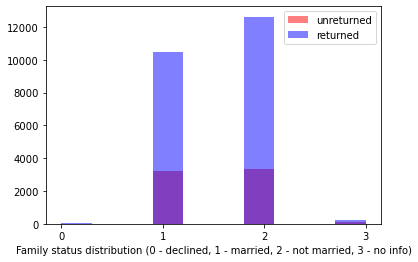

In [58]:
plt.hist(marr_unret, color = 'r', alpha = 0.5, label = "unreturned")
plt.hist(marr_ret, color = 'b', alpha = 0.5, label = "returned")
plt.xlabel('Family status distribution (0 - declined, 1 - married, 2 - not married, 3 - no info)')
plt.locator_params()
plt.xticks(range(4))
plt.legend()
plt.show()

In [51]:
marr_val_counts.MARRIAGE_RET/(marr_val_counts.MARRIAGE_RET + marr_val_counts.MARRIAGE_UNRET)

2    0.790717
1    0.765283
3    0.739938
0    0.907407
dtype: float64

Видно, что семейный статус возможно, имеет влияние на возврат кредита, но однозначного ответ дать затруднительно. Оценим наличие связи между этими величинами более строго, используя коэффициент Крамера.

In [79]:
chi2 = scipy.stats.chi2_contingency(marr_val_counts)
n = marr_val_counts.sum().sum()
r,k = marr_val_counts.shape
cramers_corrected_stat = np.sqrt(chi2[0]/n / min( (k), (r)))

print(f"Cramers stat: {cramers_corrected_stat}")
print(f"p-val: {chi2[1]}")

Cramers stat: 0.024379771613073028
p-val: 8.825862457577375e-08


Гипотезу о значении коэффициента Крамера нулю можно отвергнуть с уровнемзначимости 0.05. Семейный статус оказывает какое-то влияние на возврат кредита.
При этотм коэффициент Крамера получился довольно близким к нулю. Из этого можно сделать вывод, что связь между величинами незначительна. 

### Задание 5
Возраст (AGE): Относительно двух групп людей  вернувших и не вернувших кредит  проверьте следующие гипотезы:   a)  о равенстве медианных значений возрастов людей   b) о равенстве распределений  с помощью одного из подходящих непараметрических критериев проверки равенства средних.  Значимы ли полученные результаты с практической точки зрения ?

In [32]:
age_ret = credit_data_ret.AGE.rename("AGE_RET")
age_unret = credit_data_unret.AGE.rename("AGE_UNRET")

In [33]:
ret_unret_age_descr = pd.concat([age_ret.describe(), age_unret.describe()], axis = 1)
ret_unret_age_descr

,AGE_RET,AGE_UNRET
count,23364.000000,6636.000000
mean,35.417266,35.725738
std,9.077355,9.693438
min,21.000000,21.000000
25%,28.000000,28.000000
50%,34.000000,34.000000
75%,41.000000,42.000000
max,79.000000,75.000000


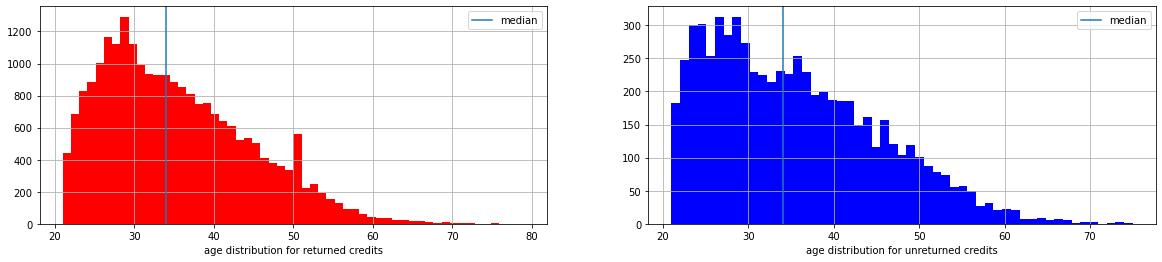

In [34]:
plt.figure(figsize=(20,4))

plt.subplot(1,2,1)
plt.grid()
plt.hist(age_ret, color = 'r', bins = age_ret.nunique())
plt.axvline(ret_unret_age_descr.loc["50%", "AGE_RET"], label="median")
plt.xlabel('age distribution for returned credits')
plt.legend()

plt.subplot(1,2,2)
plt.grid()
plt.hist(age_unret, color = 'b', bins = age_unret.nunique())
plt.axvline(ret_unret_age_descr.loc["50%", "AGE_UNRET"], label="median")
plt.xlabel('age distribution for unreturned credits')
plt.legend()


plt.show()

Анализ выборки не позволяет увидеть сильных различий с точки зрения возраста. Для проверки гипотезы о равенстве распределений построим доверительный интервал разностимедиан при помощи бутстрепа.

In [35]:
ret_median_scores = list(map(np.median, get_bootstrap_samples(age_ret.values, 1000)))
unret_median_scores = list(map(np.median, get_bootstrap_samples(age_unret.values, 1000)))
print("95% confidence interval for the returned credits median age:",  stat_intervals(ret_median_scores, 0.05))
print("95% confidence interval for the unreturned credits median age:",  stat_intervals(unret_median_scores, 0.05))


95% confidence interval for the returned credits median age: [34. 34.]
95% confidence interval for the unreturned credits median age: [34. 35.]


Доверительные интервалы практически совпадют, что не дает нам никаких оснований отвергнуть гипотезу о совпадении распределений.
Попробуем воспользоваться выборочным критерием для оценки среднего.

In [36]:
test_result = permutation_test(age_unret, age_ret, 10000)
print("p_val: %f, t_stat: %f" % (test_result))

p_val: 0.016700, t_stat: 0.308473


Выборочный критерий позволяет с отвергнуть гипотезу о равенстве распреелений по возрасту с уровнем значимости 0.05. При этом мы можем увидеть, что значение T-статистики по факту мало (~0.3). Очевидно, что такая разница в возрасте в несколько месяцев не может оказывать сильного влияния на какие бы то ни было финансовые показатели. Тем более, что средний возраст в районе ~35 лет не предполагает под собой какие-то резкие изменения в жизни, способные повлиять на платежеспособность.